In [2]:
from qiskit import QuantumCircuit, QuantumRegister

# 2 qubits pour le site 1 (3 niveaux)
site1 = QuantumRegister(2, name='site1')

# 2 qubits pour le site 2 (3 niveaux)
site2 = QuantumRegister(2, name='site2')

# 1 qubit ancilla
anc = QuantumRegister(1, name='ancilla')

# Créer le circuit
qc = QuantumCircuit(site1, site2, anc)


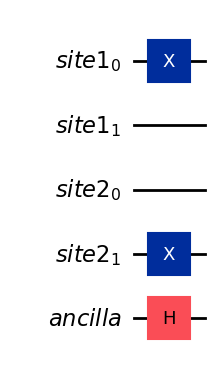

In [4]:
from qiskit import QuantumCircuit, QuantumRegister

# Définir les registres
site1 = QuantumRegister(2, name='site1')   # q0, q1
site2 = QuantumRegister(2, name='site2')   # q2, q3
anc = QuantumRegister(1, name='ancilla')   # q4

# Créer le circuit
qc = QuantumCircuit(site1, site2, anc)

# --- Site 1 = |1> → '01' → q0=1, q1=0 ---
qc.x(site1[0])  # LSB = 1 (q0)
# q1 = 0 par défaut

# --- Site 2 = |2> → '10' → q2=0, q3=1 ---
qc.x(site2[1])  # MSB = 1 (q3)
# q2 = 0 par défaut

# --- Ancilla = |+> → Hadamard sur q4 ---
qc.h(anc[0])

# Visualiser
qc.draw('mpl')


In [6]:
import numpy as np
from qiskit.quantum_info import Operator

# Matrice du créateur tronqué (4x4)
b_dag = np.zeros((4, 4), dtype=complex)

# |0⟩ → |1⟩ (00 → 01) : index 1 ← 0
b_dag[1, 0] = 1.0

# |1⟩ → |2⟩ (01 → 10) : index 2 ← 1
b_dag[2, 1] = np.sqrt(2)

# Annihilateur = hermitien conjugué
b = b_dag.conj().T

# Créer les opérateurs utilisables dans Qiskit
b_op = Operator(b)
b_dag_op = Operator(b_dag)


In [8]:
import numpy as np
from qiskit.quantum_info import Operator

# Dimension du site : 3 (niveaux 0,1,2)
dim = 3

# Créateur tronqué (b^†)
b_dag = np.zeros((dim, dim), dtype=complex)
b_dag[1, 0] = 1.0           # |0> → |1>
b_dag[2, 1] = np.sqrt(2.0)  # |1> → |2>

# Annihilateur tronqué (b)
b = b_dag.conj().T          # Hermitien conjugué

# Nombre d’occupation n̂ = b^† b
n_op = b_dag @ b

# Interaction : n̂(n̂ - 1)
interaction_op = n_op @ (n_op - np.eye(dim))


In [20]:
import numpy as np
from qiskit.quantum_info import Operator

# Tensor product using NumPy
def tensor(a, b):
    return np.kron(a, b)

dim = 3
I = np.eye(dim)

# Créateur tronqué
b_dag = np.zeros((dim, dim), dtype=complex)
b_dag[1, 0] = 1.0
b_dag[2, 1] = np.sqrt(2.0)
b = b_dag.conj().T

# Occupation
n_op = b_dag @ b
interaction_op = n_op @ (n_op - np.eye(dim))

# Tensorisé
b1 = tensor(b, I)
b1_dag = tensor(b_dag, I)
n1 = tensor(n_op, I)
interaction1 = tensor(interaction_op, I)

b2 = tensor(I, b)
b2_dag = tensor(I, b_dag)
n2 = tensor(I, n_op)
interaction2 = tensor(I, interaction_op)


In [22]:
# Paramètres physiques (valeurs exemples)
ħ = 1.0
ω1, ω2 = 1.0, 1.0
K1, K2 = 0.1, 0.1
J = 0.05

# Terme local de chaque site
H_local = ħ * ω1 * n1 + ħ * ω2 * n2

# Interaction locale (anharmonicité)
H_interaction = -0.5 * K1 * interaction1 - 0.5 * K2 * interaction2

# Couplage tunnel
H_tunnel = -J * (b1_dag @ b2 + b2_dag @ b1)

# Hamiltonien total
H_total = H_local + H_interaction + H_tunnel


In [24]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt


In [26]:
# Espace 3x3 = 9 dimensions
dim_total = 9
psi0 = np.zeros((dim_total,), dtype=complex)

# Exemple : site1 = 1 (|01>), site2 = 2 (|10>) → index = 3*1 + 2 = 5
# (row-major order: site1 ⊗ site2)
psi0[5] = 1.0


In [28]:
def evolve_state(H, psi0, t):
    U = expm(-1j * H * t)         # e^{-i H t}
    psi_t = U @ psi0              # |\psi(t)>
    return psi_t


In [30]:
times = np.linspace(0, 10, 100)
prob_site1_1 = []

for t in times:
    psi_t = evolve_state(H_total, psi0, t)
    
    # Mesurer la proba d’avoir 1 boson sur site 1 (états 3,4,5)
    prob = np.abs(psi_t[3])**2 + np.abs(psi_t[4])**2 + np.abs(psi_t[5])**2
    prob_site1_1.append(prob)


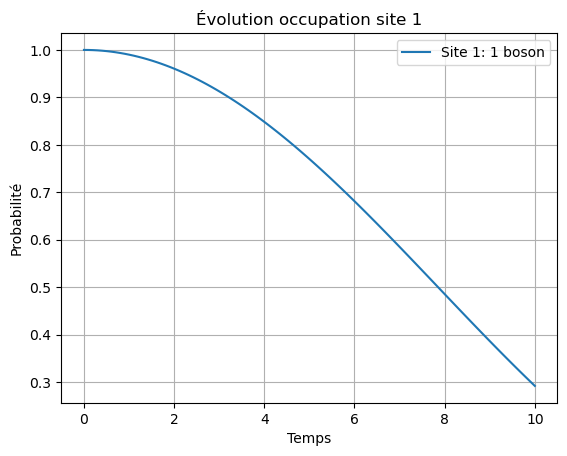

In [32]:
plt.plot(times, prob_site1_1, label="Site 1: 1 boson")
plt.xlabel("Temps")
plt.ylabel("Probabilité")
plt.title("Évolution occupation site 1")
plt.legend()
plt.grid()
plt.show()


In [34]:
def measure_site1_occupation(psi_t):
    n1_exp = 0
    for idx in range(9):
        n1 = idx // 3  # site1 = ligne dans produit tensoriel
        prob = np.abs(psi_t[idx])**2
        n1_exp += n1 * prob
    return n1_exp


In [36]:
def measure_site2_occupation(psi_t):
    n2_exp = 0
    for idx in range(9):
        n2 = idx % 3
        prob = np.abs(psi_t[idx])**2
        n2_exp += n2 * prob
    return n2_exp


In [38]:
def measure_ancilla(psi_t):
    prob_0 = np.sum(np.abs(psi_t[0:9])**2)
    prob_1 = np.sum(np.abs(psi_t[9:18])**2)
    return prob_0, prob_1


In [46]:
def measure_site1_occupation(psi_t):
    n1_exp = 0
    for i in range(9):
        n1 = i // 3
        prob = np.abs(psi_t[i])**2
        n1_exp += n1 * prob
    return n1_exp


In [50]:
psi0 = np.zeros(18, dtype=complex)
psi0[5] = 1 / np.sqrt(2)    # ancilla = 0, état = index 5
psi0[14] = 1 / np.sqrt(2)   # ancilla = 1, état = index 5 + 9 = 14
I2 = np.eye(2)
H_total_with_ancilla = np.kron(H_total, I2)  # (9x9) ⊗ (2x2) = 18x18


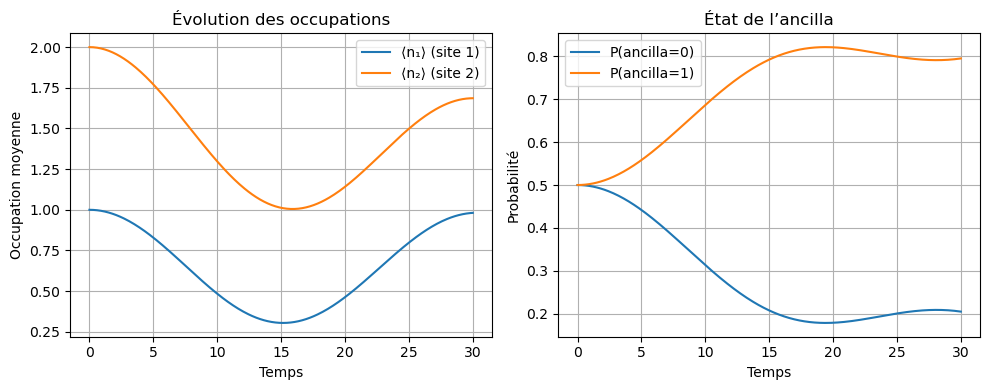

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

# --------- PARAMÈTRES DU SYSTÈME ---------
ħ = 1.0
ω1, ω2 = 1.0, 1.0       # Fréquences des sites
K1, K2 = 0.1, 0.1       # Anharmonicités locales
J = 0.05                # Couplage tunnel
dim_site = 3            # 3 niveaux par site (tronqué)
dim_total = dim_site * dim_site * 2  # 3x3 pour les sites ×2 pour l'ancilla

# --------- OPÉRATEURS DU SITE (3 niveaux) ---------
b_dag_site = np.zeros((dim_site, dim_site), dtype=complex)
b_dag_site[1, 0] = 1.0
b_dag_site[2, 1] = np.sqrt(2)
b_site = b_dag_site.conj().T
n_site = b_dag_site @ b_site
interaction_site = n_site @ (n_site - np.eye(dim_site))

I3 = np.eye(dim_site)
I2 = np.eye(2)

# --------- OPÉRATEURS TENSORISÉS ---------
def kron3(a, b, c):
    return np.kron(np.kron(a, b), c)

b1 = kron3(b_site, I3, I2)
b1_dag = kron3(b_dag_site, I3, I2)
n1 = kron3(n_site, I3, I2)
interaction1 = kron3(interaction_site, I3, I2)

b2 = kron3(I3, b_site, I2)
b2_dag = kron3(I3, b_dag_site, I2)
n2 = kron3(I3, n_site, I2)
interaction2 = kron3(I3, interaction_site, I2)

# --------- HAMILTONIEN TOTAL ---------
H_local = ħ * ω1 * n1 + ħ * ω2 * n2
H_interaction = -0.5 * K1 * interaction1 - 0.5 * K2 * interaction2
H_tunnel = -J * (b1_dag @ b2 + b2_dag @ b1)
H_total = H_local + H_interaction + H_tunnel

# --------- ÉTAT INITIAL ---------
# |ψ(0)⟩ = (|1,2⟩⊗|0⟩ + |1,2⟩⊗|1⟩) / √2
psi0 = np.zeros(dim_total, dtype=complex)
index_base = 3 * 1 + 2  # site1=1, site2=2 → index=5
psi0[index_base] = 1 / np.sqrt(2)        # ancilla=0
psi0[index_base + 9] = 1 / np.sqrt(2)    # ancilla=1

# --------- FONCTIONS DE MESURE ---------
def evolve_state(H, psi0, t):
    U = expm(-1j * H * t)
    return U @ psi0

def measure_ancilla(psi):
    prob0 = np.sum(np.abs(psi[:9])**2)
    prob1 = np.sum(np.abs(psi[9:])**2)
    return prob0, prob1

def measure_n1(psi):
    n1_avg = 0
    for anc in [0, 1]:
        offset = anc * 9
        for idx in range(9):
            n1 = idx // 3
            prob = np.abs(psi[offset + idx])**2
            n1_avg += n1 * prob
    return n1_avg

def measure_n2(psi):
    n2_avg = 0
    for anc in [0, 1]:
        offset = anc * 9
        for idx in range(9):
            n2 = idx % 3
            prob = np.abs(psi[offset + idx])**2
            n2_avg += n2 * prob
    return n2_avg

# --------- ÉVOLUTION DANS LE TEMPS ---------
times = np.linspace(0, 30, 300)
n1_vals, n2_vals, anc_probs = [], [], []

for t in times:
    psi_t = evolve_state(H_total, psi0, t)
    n1_vals.append(measure_n1(psi_t))
    n2_vals.append(measure_n2(psi_t))
    anc_probs.append(measure_ancilla(psi_t))

# --------- AFFICHAGE DES RÉSULTATS ---------
anc_0, anc_1 = zip(*anc_probs)

plt.figure(figsize=(10, 4))

# Occupation des sites
plt.subplot(1, 2, 1)
plt.plot(times, n1_vals, label='⟨n₁⟩ (site 1)')
plt.plot(times, n2_vals, label='⟨n₂⟩ (site 2)')
plt.xlabel('Temps')
plt.ylabel('Occupation moyenne')
plt.title('Évolution des occupations')
plt.legend()
plt.grid()

# État de l’ancilla
plt.subplot(1, 2, 2)
plt.plot(times, anc_0, label='P(ancilla=0)')
plt.plot(times, anc_1, label='P(ancilla=1)')
plt.xlabel('Temps')
plt.ylabel('Probabilité')
plt.title('État de l’ancilla')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [58]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import expm

# ---------- Paramètres physiques ----------
ħ = 1.0
ω1, ω2 = 1.0, 1.0
K1, K2 = 0.1, 0.1
J = 0.05
t = 5.0

# ---------- Opérateurs de base (3 niveaux) ----------
dim_site = 3
dim_ancilla = 2
dim_total = dim_site * dim_site * dim_ancilla  # 18
I3 = np.eye(3)
I2 = np.eye(2)

b_dag = np.zeros((3, 3), dtype=complex)
b_dag[1, 0] = 1
b_dag[2, 1] = np.sqrt(2)
b = b_dag.conj().T
n_op = b_dag @ b
interaction = n_op @ (n_op - np.eye(3))

def kron3(a, b, c):
    return np.kron(np.kron(a, b), c)

b1 = kron3(b, I3, I2)
b1_dag = kron3(b_dag, I3, I2)
n1 = kron3(n_op, I3, I2)
int1 = kron3(interaction, I3, I2)

b2 = kron3(I3, b, I2)
b2_dag = kron3(I3, b_dag, I2)
n2 = kron3(I3, n_op, I2)
int2 = kron3(I3, interaction, I2)

H_local = ħ * ω1 * n1 + ħ * ω2 * n2
H_int = -0.5 * K1 * int1 - 0.5 * K2 * int2
H_tunnel = -J * (b1_dag @ b2 + b2_dag @ b1)
H = H_local + H_int + H_tunnel

# ---------- Unité d'évolution ----------
U = expm(-1j * H * t)

# Étendre à 32 dimensions (5 qubits)
U_qiskit = np.eye(32, dtype=complex)
U_qiskit[:18, :18] = U
gate = UnitaryGate(U_qiskit, label="exp(-iHt)")

# ---------- Préparation de l'état initial ----------
q = QuantumRegister(5)
qc = QuantumCircuit(q)

# site1 = |1⟩ = '01' → q0=1
qc.x(q[0])
# site2 = |2⟩ = '10' → q3=1
qc.x(q[3])
# ancilla = |+⟩ = H(q4)
qc.h(q[4])

# Appliquer le Hamiltonien
qc.append(gate, q)

# Simuler et afficher l'état final
sv = Statevector.from_instruction(qc)
print("État final :")
print(sv)

# Facultatif : dessiner l'état
sv.draw(output='text')


État final :
Statevector([ 0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        , -0.07578392-0.22474803j,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        , -0.51445718+0.35046263j,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        , -0.07578392-0.22474803j,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.70710678+0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0. 

[0.+0.j,0.+0.j,0.+0.j,...,0.+0.j,0.+0.j,0.+0.j]

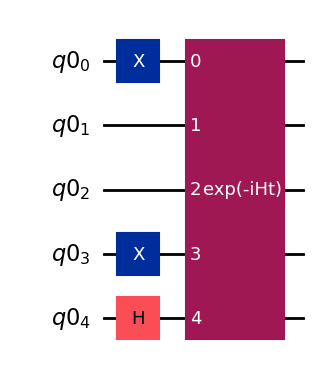

In [60]:
qc.draw('mpl')

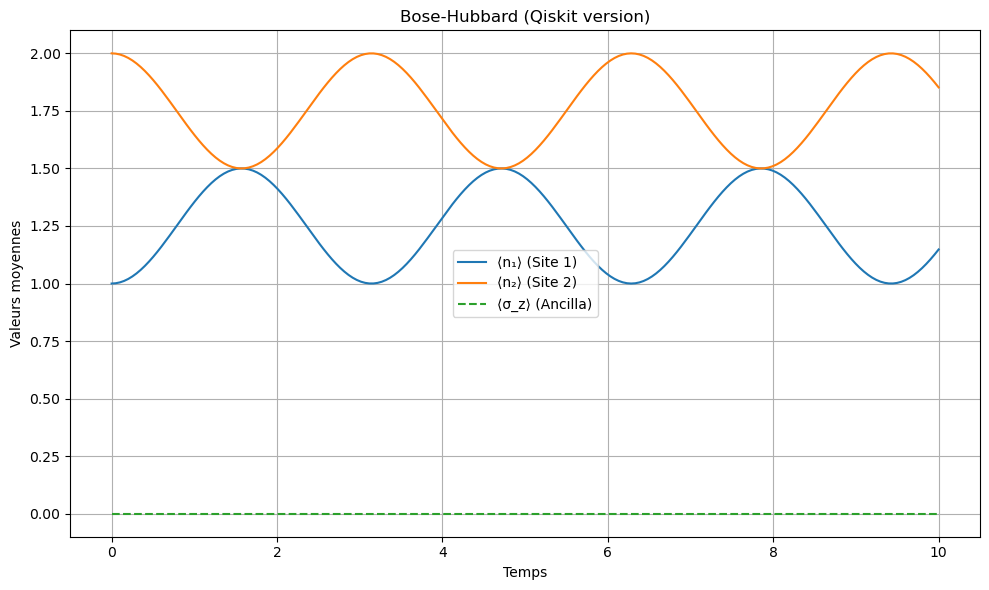

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit.quantum_info import Operator, Statevector, partial_trace, DensityMatrix

# --- PARAMÈTRES ---
N = 3   # 3 niveaux (0,1,2 bosons) par site
q = 2   # Qubit ancilla
U = 1.0
J = 0.5
tlist = np.linspace(0, 10, 200)

# --- BASES ---
id_N = np.eye(N)
id_q = np.eye(q)

# Création des opérateurs de destruction
def destroy(N):
    d = np.zeros((N, N))
    for n in range(1, N):
        d[n - 1, n] = np.sqrt(n)
    return d

a = destroy(N)
adag = a.T.conj()
n_op = adag @ a

# Opérateurs site 1 et 2 (tensorisés)
a1 = np.kron(np.kron(a, id_N), id_q)
a2 = np.kron(np.kron(id_N, a), id_q)
n1 = a1.T.conj() @ a1
n2 = a2.T.conj() @ a2

# Projecteur |1⟩⟨1| sur l’ancilla
P1 = np.kron(np.kron(id_N, id_N), np.array([[0,0],[0,1]]))

# Tunneling avec contrôle par ancilla
H_tunnel = -J * (a1.T.conj() @ a2 + a2.T.conj() @ a1) @ P1

# Interaction
H_U = (U / 2) * (n1 @ (n1 - np.eye(N**2 * q)) + n2 @ (n2 - np.eye(N**2 * q)))

# Hamiltonien total
H = H_U + H_tunnel

# --- État initial ---
# Site 1 = 1 boson, Site 2 = 2 bosons
psi_site1 = np.zeros(N); psi_site1[1] = 1
psi_site2 = np.zeros(N); psi_site2[2] = 1
psi_anc = (1/np.sqrt(2)) * np.array([1, 1])  # (|0⟩ + |1⟩)/√2

# Produit tensoriel
psi0 = np.kron(np.kron(psi_site1, psi_site2), psi_anc)

# --- Évolution ---
expect_n1 = []
expect_n2 = []
expect_z = []

# sigma_z pour la qubit
sigma_z = np.array([[1, 0], [0, -1]])
sigma_z_anc = np.kron(np.kron(id_N, id_N), sigma_z)

for t in tlist:
    U_t = expm(-1j * H * t)
    psi_t = U_t @ psi0
    rho_t = np.outer(psi_t, psi_t.conj())

    exp_n1 = np.trace(rho_t @ n1).real
    exp_n2 = np.trace(rho_t @ n2).real
    exp_sz = np.trace(rho_t @ sigma_z_anc).real

    expect_n1.append(exp_n1)
    expect_n2.append(exp_n2)
    expect_z.append(exp_sz)

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(tlist, expect_n1, label="⟨n₁⟩ (Site 1)")
plt.plot(tlist, expect_n2, label="⟨n₂⟩ (Site 2)")
plt.plot(tlist, expect_z, label="⟨σ_z⟩ (Ancilla)", linestyle='--')
plt.xlabel("Temps")
plt.ylabel("Valeurs moyennes")
plt.title("Bose-Hubbard (Qiskit version)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


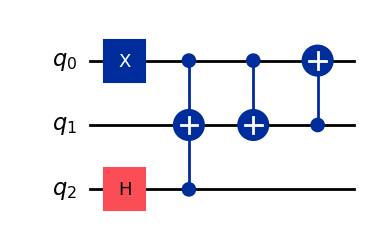

In [72]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

# Créer un circuit quantique de 3 qubits
qc = QuantumCircuit(3)

# Initialiser l’ancilla (qubit 2) dans (|0⟩ + |1⟩)/√2
qc.h(2)

# Initialiser site 1 (qubit 0) à |1⟩ (équivalent symbolique d’un boson présent)
qc.x(0)

# Site 2 (qubit 1) reste à |0⟩ (aucun boson)

# Contrôler un tunneling entre site 1 et site 2, conditionné sur l’ancilla = |1⟩
# On peut approximer cela avec un Toffoli suivi d’un SWAP contrôlé (simulé symboliquement)

# Étape 1 : simulation de transfert conditionnel
qc.ccx(2, 0, 1)  # Si ancilla=1 et site1=1 => met site2 à 1
qc.cx(0, 1)      # Transfert (approximé)
qc.cx(1, 0)      # Transfert (approximé)

# Mesure (facultative ici, on peut aussi observer l’état quantique)
qc.draw('mpl')


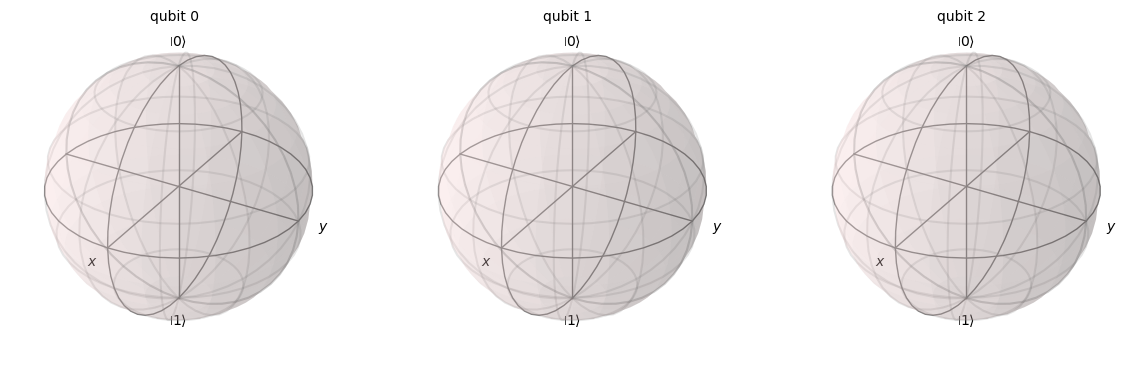

In [74]:
backend = Aer.get_backend('statevector_simulator')
state = Statevector.from_instruction(qc)
state.draw('bloch')
